In [1]:
import time
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import arabic_reshaper
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Use MobileNetV2 preprocessing
from bidi.algorithm import get_display  # For proper Arabic text display

In [2]:
# ------------------------------
# 1. DATA LOADING & PREPROCESSING
# ------------------------------

# Path to the dataset (each subfolder corresponds to an ArSL letter)
dataset_path = 'RGB ArSL dataset'

In [3]:
def load_dataset(folder):
    """Load dataset from the folder containing subfolders for each letter."""
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert BGR to RGB and resize to 224x224
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# Load images and labels
X, y = load_dataset(dataset_path)

In [5]:
# Encode labels to integers and then to one-hot vectors
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [6]:
# Save label classes for later inference
np.save('label_classes.npy', label_encoder.classes_)

In [7]:
# Create a dynamic label map based on the encoder's order
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"Original Label Map: {label_map}")


Original Label Map: {0: 'Ain', 1: 'Al', 2: 'Alef', 3: 'Beh', 4: 'Dad', 5: 'Dal', 6: 'Feh', 7: 'Ghain', 8: 'Hah', 9: 'Heh', 10: 'Jeem', 11: 'Kaf', 12: 'Khah', 13: 'Laa', 14: 'Lam', 15: 'Meem', 16: 'Noon', 17: 'Qaf', 18: 'Reh', 19: 'Sad', 20: 'Seen', 21: 'Sheen', 22: 'Tah', 23: 'Teh', 24: 'Teh_Marbuta', 25: 'Thal', 26: 'Theh', 27: 'Waw', 28: 'Yeh', 29: 'Zah', 30: 'Zain', 31: 'masafa', 32: 'mash'}


In [8]:
# Updated mapping: assign unique tokens for special commands.
english_to_arabic = {
    'Ain': 'ع', 'Al': 'ال', 'Alef': 'ا', 'Beh': 'ب', 'Dad': 'ض', 'Dal': 'د',
    'Feh': 'ف', 'Ghain': 'غ', 'Hah': 'ح', 'Heh': 'ه', 'Jeem': 'ج', 'Kaf': 'ك',
    'Khah': 'خ', 'Laa': 'لا', 'Lam': 'ل',
    'masafa': '<space>',  # special token for space
    'mash': '<delete>',   # special token for delete
    'Meem': 'م', 'Noon': 'ن', 'Qaf': 'ق',
    'Reh': 'ر', 'Sad': 'ص', 'Seen': 'س', 'Sheen': 'ش', 'Tah': 'ط', 'Teh': 'ت',
    'Teh_Marbuta': 'ة', 'Thal': 'ذ', 'Theh': 'ث', 'Waw': 'و', 'Yeh': 'ي',
    'Zah': 'ظ', 'Zain': 'ز'
}

In [9]:
# Remap label names to their corresponding Arabic representation
label_map = {i: english_to_arabic.get(label, label) for i, label in enumerate(label_encoder.classes_)}
print(f"Arabic Label Map: {label_map}")

Arabic Label Map: {0: 'ع', 1: 'ال', 2: 'ا', 3: 'ب', 4: 'ض', 5: 'د', 6: 'ف', 7: 'غ', 8: 'ح', 9: 'ه', 10: 'ج', 11: 'ك', 12: 'خ', 13: 'لا', 14: 'ل', 15: 'م', 16: 'ن', 17: 'ق', 18: 'ر', 19: 'ص', 20: 'س', 21: 'ش', 22: 'ط', 23: 'ت', 24: 'ة', 25: 'ذ', 26: 'ث', 27: 'و', 28: 'ي', 29: 'ظ', 30: 'ز', 31: '<space>', 32: '<delete>'}


In [10]:
# MobileNetV2 expects inputs normalized with a specific function
X = preprocess_input(X)


In [11]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [12]:
# ------------------------------
# 2. BUILD THE MOBILENETV2–BASED MODEL
# ------------------------------

def create_mobilenetv2_model(num_classes):
    """
    Create a MobileNetV2–based model for Arabic Sign Language recognition.
    Uses ImageNet pre-trained weights with custom top layers.
    """
    # Load MobileNetV2 base model without the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model for initial training
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        # A slightly lighter classification head for MobileNetV2:
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), use_bias=False),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', use_bias=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', use_bias=False),
        BatchNormalization(),
        Dropout(0.3),
        # Final softmax output for multi-class classification
        Dense(num_classes, activation='softmax')
    ])
    
    return model

In [13]:
# Create and compile the model
num_classes = len(label_encoder.classes_)
model = create_mobilenetv2_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,085,025 (11.77 MB)

 Trainable params: 825,249 (3.15 MB)

 Non-trainable params: 2,259,776 (8.62 MB)

In [14]:
# ------------------------------
# 3. DATA AUGMENTATION & MODEL TRAINING
# ------------------------------

# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
# Compute balanced class weights based on the training data
y_train_int = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: 1.0477550372838331, 1: 0.9055258467023173, 2: 0.8894276094276095, 3: 0.8004848484848485, 4: 0.9351458510337015, 5: 1.093558536181487, 6: 0.9906990699069907, 7: 1.0107131925313744, 8: 1.0210265924551638, 9: 0.9667691406821841, 10: 1.1702994860889597, 11: 0.9809863339275104, 12: 0.9762010347376201, 13: 0.897404538660144, 14: 0.9762010347376201, 15: 1.005634231764885, 16: 1.0532695374800638, 17: 1.1911976911976911, 18: 1.064474532559639, 19: 0.9264870931537598, 20: 0.9667691406821841, 21: 0.9307963354474983, 22: 1.1771836007130125, 23: 0.7609171563544187, 24: 1.0006060606060605, 25: 1.2746574020459371, 26: 0.8201689021361153, 27: 0.9906990699069907, 28: 0.8933982683982684, 29: 1.0532695374800638, 30: 1.3706932337069324, 31: 1.220251293422025, 32: 1.2055494706097116}


In [16]:
# Set up callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_asl_mobilenetv2_model.keras', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

In [17]:
# ----------- Phase 1: Train with Frozen Base -----------
initial_epochs = 30
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 187s 858ms/step - accuracy: 0.0514 - loss: 11.4475 - val_accuracy: 0.1592 - val_loss: 9.9860 - learning_rate: 1.0000e-04
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 169s 814ms/step - accuracy: 0.1275 - loss: 10.3557 - val_accuracy: 0.2573 - val_loss: 9.1881 - learning_rate: 1.0000e-04
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 170s 821ms/step - accuracy: 0.1895 - loss: 9.5871 - val_accuracy: 0.3281 - val_loss: 8.5184 - learning_rate: 1.0000e-04
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 168s 813ms/step - accuracy: 0.2366 - loss: 8.9438 - val_accuracy: 0.3826 - val_loss: 7.9750 - learning_rate: 1.0000e-04
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 169s 815ms/step - accuracy: 0.2686 - loss: 8.3828 - val_accuracy: 0.4395 - val_loss: 7.4872 - learning_rate: 1.0000e-04
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 168s 811ms/step - accuracy: 0.3029 - loss: 7.8712 - val_accuracy: 0.4722 - val_loss: 7.0357 - learning_rate: 1.0000e-04
Epoch 7/30
207/207 ━━━━━━━━━━━━━━━━━━━

In [18]:
# (Optional) List base model layer names for reference
base_model = model.layers[0]
print("\nMobileNetV2 Base Model Layers:")
for idx, layer in enumerate(base_model.layers):
    print(f"Layer {idx}: {layer.name}")


MobileNetV2 Base Model Layers:
Layer 0: input_layer
Layer 1: Conv1
Layer 2: bn_Conv1
Layer 3: Conv1_relu
Layer 4: expanded_conv_depthwise
Layer 5: expanded_conv_depthwise_BN
Layer 6: expanded_conv_depthwise_relu
Layer 7: expanded_conv_project
Layer 8: expanded_conv_project_BN
Layer 9: block_1_expand
Layer 10: block_1_expand_BN
Layer 11: block_1_expand_relu
Layer 12: block_1_pad
Layer 13: block_1_depthwise
Layer 14: block_1_depthwise_BN
Layer 15: block_1_depthwise_relu
Layer 16: block_1_project
Layer 17: block_1_project_BN
Layer 18: block_2_expand
Layer 19: block_2_expand_BN
Layer 20: block_2_expand_relu
Layer 21: block_2_depthwise
Layer 22: block_2_depthwise_BN
Layer 23: block_2_depthwise_relu
Layer 24: block_2_project
Layer 25: block_2_project_BN
Layer 26: block_2_add
Layer 27: block_3_expand
Layer 28: block_3_expand_BN
Layer 29: block_3_expand_relu
Layer 30: block_3_pad
Layer 31: block_3_depthwise
Layer 32: block_3_depthwise_BN
Layer 33: block_3_depthwise_relu
Layer 34: block_3_proj

In [19]:
# ----------- Phase 2: Fine-tuning by Unfreezing the Last 30 Layers -----------
# Unfreeze the last 30 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
print("\nFine-tuning: The following layers are now trainable:")
for layer in base_model.layers:
    if layer.trainable:
        print(layer.name)



Fine-tuning: The following layers are now trainable:
block_13_project_BN
block_14_expand
block_14_expand_BN
block_14_expand_relu
block_14_depthwise
block_14_depthwise_BN
block_14_depthwise_relu
block_14_project
block_14_project_BN
block_14_add
block_15_expand
block_15_expand_BN
block_15_expand_relu
block_15_depthwise
block_15_depthwise_BN
block_15_depthwise_relu
block_15_project
block_15_project_BN
block_15_add
block_16_expand
block_16_expand_BN
block_16_expand_relu
block_16_depthwise
block_16_depthwise_BN
block_16_depthwise_relu
block_16_project
block_16_project_BN
Conv_1
Conv_1_bn
out_relu


In [20]:
# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_tune_epochs = 25
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 31/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 161s 743ms/step - accuracy: 0.4882 - loss: 2.7995 - val_accuracy: 0.6586 - val_loss: 2.1183 - learning_rate: 1.0000e-05
Epoch 32/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 158s 764ms/step - accuracy: 0.5815 - loss: 2.4076 - val_accuracy: 0.6780 - val_loss: 2.0071 - learning_rate: 1.0000e-05
Epoch 33/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 159s 767ms/step - accuracy: 0.6126 - loss: 2.2559 - val_accuracy: 0.7082 - val_loss: 1.8909 - learning_rate: 1.0000e-05
Epoch 34/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 158s 765ms/step - accuracy: 0.6534 - loss: 2.0991 - val_accuracy: 0.7415 - val_loss: 1.8099 - learning_rate: 1.0000e-05
Epoch 35/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 158s 762ms/step - accuracy: 0.6569 - loss: 2.0767 - val_accuracy: 0.7476 - val_loss: 1.7630 - learning_rate: 1.0000e-05
Epoch 36/55
207/207 ━━━━━━━━━━━━━━━━━━━━ 157s 760ms/step - accuracy: 0.6799 - loss: 2.0209 - val_accuracy: 0.7639 - val_loss: 1.7199 - learning_rate: 1.0000e-05
Epoch 37/55
207/207 ━━━━━━━━━━━━━━

In [21]:
# Save the final model
model.save('asl_mobilenetv2_model.keras')


In [22]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'\nValidation Accuracy: {val_acc * 100:.2f}%')

52/52 - 20s - 380ms/step - accuracy: 0.8626 - loss: 1.3167

Validation Accuracy: 86.26%


## Model Evaluation (Test Accuracy, Plots, etc.)

In [2]:
# Load label classes saved earlier
label_classes = np.load('label_classes.npy', allow_pickle=True)
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}
print("Loaded Label Map:", label_map)

Loaded Label Map: {0: 'Ain', 1: 'Al', 2: 'Alef', 3: 'Beh', 4: 'Dad', 5: 'Dal', 6: 'Feh', 7: 'Ghain', 8: 'Hah', 9: 'Heh', 10: 'Jeem', 11: 'Kaf', 12: 'Khah', 13: 'Laa', 14: 'Lam', 15: 'Meem', 16: 'Noon', 17: 'Qaf', 18: 'Reh', 19: 'Sad', 20: 'Seen', 21: 'Sheen', 22: 'Tah', 23: 'Teh', 24: 'Teh_Marbuta', 25: 'Thal', 26: 'Theh', 27: 'Waw', 28: 'Yeh', 29: 'Zah', 30: 'Zain', 31: 'masafa', 32: 'mash'}


In [3]:
# (Re)load your evaluation/test dataset – here we assume the same loading function as before.
def load_dataset(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# Specify the test or evaluation dataset path (it could be a dedicated folder)
test_dataset_path = 'RGB ArSL dataset'  # adjust as needed
X_test, y_test = load_dataset(test_dataset_path)

In [5]:
# Preprocess the test images
X_test = preprocess_input(X_test)
y_test_encoded = label_encoder.transform(y_test)
y_test_cat = tf.keras.utils.to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

In [6]:
# Load the saved model
model = load_model('asl_mobilenetv2_model.keras')

In [7]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=2)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

258/258 - 107s - 415ms/step - accuracy: 0.9385 - loss: 1.1354
Test Accuracy: 93.85%


In [8]:
# Get predictions for evaluation metrics
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

258/258 ━━━━━━━━━━━━━━━━━━━━ 107s 411ms/step


In [9]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

         Ain       0.98      0.98      0.98       244
          Al       0.96      0.97      0.97       276
        Alef       0.97      0.98      0.98       287
         Beh       0.90      0.94      0.92       307
         Dad       0.96      0.97      0.96       266
         Dal       0.88      0.83      0.85       235
         Feh       0.88      0.85      0.86       255
       Ghain       0.98      0.96      0.97       230
         Hah       0.92      0.95      0.94       246
         Heh       0.96      0.95      0.96       253
        Jeem       0.96      0.94      0.95       210
         Kaf       0.89      0.92      0.90       264
        Khah       0.98      0.94      0.96       250
         Laa       0.97      0.96      0.96       268
         Lam       0.94      0.98      0.96       260
        Meem       0.93      0.91      0.92       253
        Noon       0.97      0.95      0.96       237
   

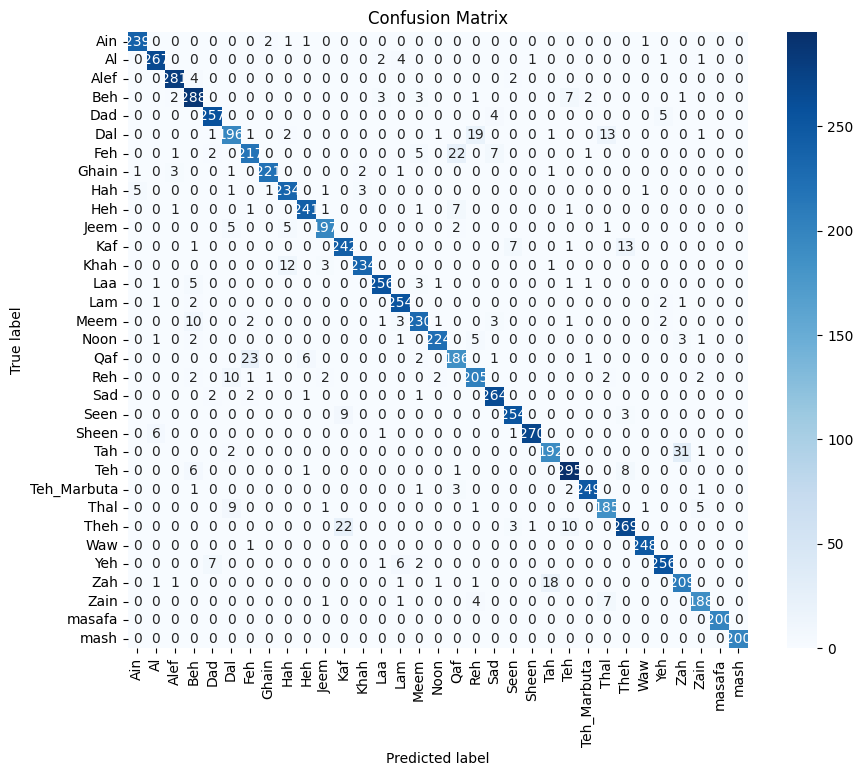

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Real-Time Inference via Webcam

In [11]:
# Load saved model for real time
model = load_model('asl_mobilenetv2_model.keras')

In [12]:
# Load label classes and recreate label map
label_classes = np.load('label_classes.npy', allow_pickle=True)
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}
print("Loaded Label Map:", label_map)

Loaded Label Map: {0: 'Ain', 1: 'Al', 2: 'Alef', 3: 'Beh', 4: 'Dad', 5: 'Dal', 6: 'Feh', 7: 'Ghain', 8: 'Hah', 9: 'Heh', 10: 'Jeem', 11: 'Kaf', 12: 'Khah', 13: 'Laa', 14: 'Lam', 15: 'Meem', 16: 'Noon', 17: 'Qaf', 18: 'Reh', 19: 'Sad', 20: 'Seen', 21: 'Sheen', 22: 'Tah', 23: 'Teh', 24: 'Teh_Marbuta', 25: 'Thal', 26: 'Theh', 27: 'Waw', 28: 'Yeh', 29: 'Zah', 30: 'Zain', 31: 'masafa', 32: 'mash'}


In [13]:
# (Optional) remap using your updated English-to-Arabic mapping:
english_to_arabic = {
    'Ain': 'ع', 'Al': 'ال', 'Alef': 'ا', 'Beh': 'ب', 'Dad': 'ض', 'Dal': 'د',
    'Feh': 'ف', 'Ghain': 'غ', 'Hah': 'ح', 'Heh': 'ه', 'Jeem': 'ج', 'Kaf': 'ك',
    'Khah': 'خ', 'Laa': 'لا', 'Lam': 'ل',
    'masafa': '<space>',  # special token for space
    'mash': '<delete>',   # special token for delete
    'Meem': 'م', 'Noon': 'ن', 'Qaf': 'ق',
    'Reh': 'ر', 'Sad': 'ص', 'Seen': 'س', 'Sheen': 'ش', 'Tah': 'ط', 'Teh': 'ت',
    'Teh_Marbuta': 'ة', 'Thal': 'ذ', 'Theh': 'ث', 'Waw': 'و', 'Yeh': 'ي',
    'Zah': 'ظ', 'Zain': 'ز'
}
label_map = {i: english_to_arabic.get(label, label) for i, label in label_map.items()}
print("Loaded Label Map for Inference:", label_map)

Loaded Label Map for Inference: {0: 'ع', 1: 'ال', 2: 'ا', 3: 'ب', 4: 'ض', 5: 'د', 6: 'ف', 7: 'غ', 8: 'ح', 9: 'ه', 10: 'ج', 11: 'ك', 12: 'خ', 13: 'لا', 14: 'ل', 15: 'م', 16: 'ن', 17: 'ق', 18: 'ر', 19: 'ص', 20: 'س', 21: 'ش', 22: 'ط', 23: 'ت', 24: 'ة', 25: 'ذ', 26: 'ث', 27: 'و', 28: 'ي', 29: 'ظ', 30: 'ز', 31: '<space>', 32: '<delete>'}


In [35]:
# Set up webcam capture
cap = cv2.VideoCapture(0)
captured_letters = []  # To store the predicted sentence
last_predicted_label = None
frames_with_same_letter = 0
cooldown_threshold = 7  # Number of consecutive frames required to register a letter
idle_timeout = 15       # Seconds of inactivity to end the session
last_activity_time = time.time()

def format_arabic_text(letters):
    """Format Arabic text to display properly from right to left."""
    return arabic_reshaper.reshape(''.join(letters))

def draw_text(frame, text, position):
    """Draw text on the video frame using PIL."""
    font_path = "arial.ttf"  # Ensure this file is available in your working directory
    font = ImageFont.truetype(font_path, 35)
    img_pil = Image.fromarray(frame)
    draw = ImageDraw.Draw(img_pil)
    draw.text(position, text, font=font, fill=(0, 255, 0))
    return np.array(img_pil)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Dynamically define Region of Interest (ROI) based on frame dimensions
    height, width, _ = frame.shape
    roi_size = min(height, width) // 2  # Adjust ROI size as needed
    center_x, center_y = width // 2, height // 2
    start_x = max(center_x - roi_size // 2, 0)
    end_x = start_x + roi_size
    start_y = max(center_y - roi_size // 2, 0)
    end_y = start_y + roi_size
    roi = frame[start_y:end_y, start_x:end_x]
    
    # Draw ROI rectangle
    cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)

    # Preprocess ROI to match model input (224x224)
    roi_resized = cv2.resize(roi, (224, 224))
    roi_resized = preprocess_input(roi_resized)
    roi_resized = np.expand_dims(roi_resized, axis=0)

    # Prediction
    prediction = model.predict(roi_resized, verbose=0)
    confidence = np.max(prediction)
    predicted_id = np.argmax(prediction)
    predicted_label = label_map.get(predicted_id, '')

    # Filter out low-confidence predictions
    if confidence < 0.7:
        predicted_label = None

    # Check for consistent predictions over consecutive frames
    if predicted_label == last_predicted_label:
        frames_with_same_letter += 1
    else:
        frames_with_same_letter = 0

    # Register letter when consistency threshold is reached
    if frames_with_same_letter >= cooldown_threshold:
        if predicted_label == '<space>':  # Interpret as space
            captured_letters.append(' ')
        elif predicted_label == '<delete>' and captured_letters:  # Delete last letter
            captured_letters.pop()
        elif predicted_label and predicted_label not in ['<space>', '<delete>']:
            captured_letters.append(predicted_label)
        # Reset after a successful prediction
        last_predicted_label = None
        frames_with_same_letter = 0
        last_activity_time = time.time()
    else:
        last_predicted_label = predicted_label

    # Check for inactivity timeout
    if time.time() - last_activity_time > idle_timeout:
        print("Final Sentence:", format_arabic_text(captured_letters))
        break

    # Draw the sentence on the frame
    sentence = format_arabic_text(captured_letters)
    frame = draw_text(frame, sentence, (10, 30))
    
    cv2.imshow('ASL Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("Final Sentence:", format_arabic_text(captured_letters))
        break

cap.release()
cv2.destroyAllWindows()



Final Sentence: ﻩ
